In [ ]:
# Upload kaggle.json (drag/drop or file picker)
#from google.colab import files
#files.upload()


In [ ]:
# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle API
!pip install -q kaggle


In [ ]:
# Facebook Check-In dataset (from the playground competition)
!kaggle competitions download -c facebook-v-predicting-check-ins

# Unzip
!unzip facebook-v-predicting-check-ins.zip


facebook-v-predicting-check-ins.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  facebook-v-predicting-check-ins.zip
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: [n],[A]
error:  invalid response [[n],[A]]
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd

# Read train.csv.zip directly
train = pd.read_csv("train.csv.zip")

# Shape and head
print("Dataset Shape:", train.shape)
print("\nFirst 5 rows:")
display(train.head())

# Check for missing values
print("\nMissing values:")
print(train.isnull().sum())

# Unique target labels
unique_places = train['place_id'].nunique()
print(f"\nNumber of unique place_id values: {unique_places}")


Dataset Shape: (29118021, 6)

First 5 rows:


,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949



Missing values:
row_id      0
x           0
y           0
accuracy    0
time        0
place_id    0
dtype: int64

Number of unique place_id values: 108390


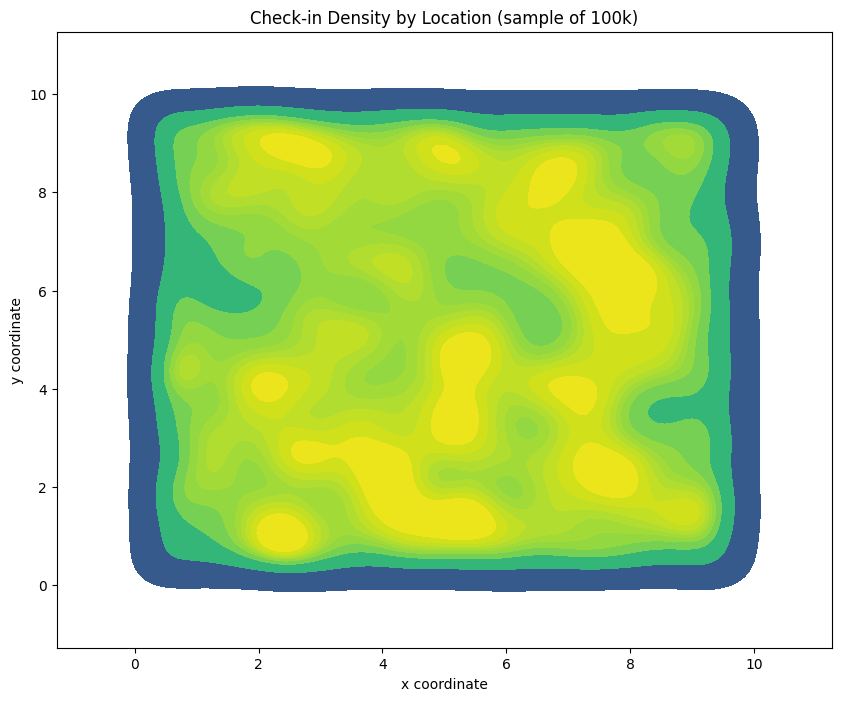

In [ ]:
# Data distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Plot density of check-ins by location
plt.figure(figsize=(10, 8))
sns.kdeplot(data=train.sample(100000), x="x", y="y", cmap="viridis", fill=True, thresh=0.05)
plt.title("Check-in Density by Location (sample of 100k)")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.show()


In [ ]:
# Time converting

# Time is given in minutes — convert to meaningful units
train['hour'] = (train['time'] // 60) % 24
train['weekday'] = (train['time'] // (60*24)) % 7
train['month'] = (train['time'] // (60*24*30)) % 12
train['year'] = train['time'] // (60*24*365)

# Optionally drop original time if needed later
# train.drop(columns=['time'], inplace=True)

# Preview
train[['time', 'hour', 'weekday', 'month', 'year']].head()


,time,hour,weekday,month,year
0,470702,21,4,10,0
1,186555,13,3,4,0
2,322648,1,0,7,0
3,704587,7,6,4,1
4,472130,20,5,10,0


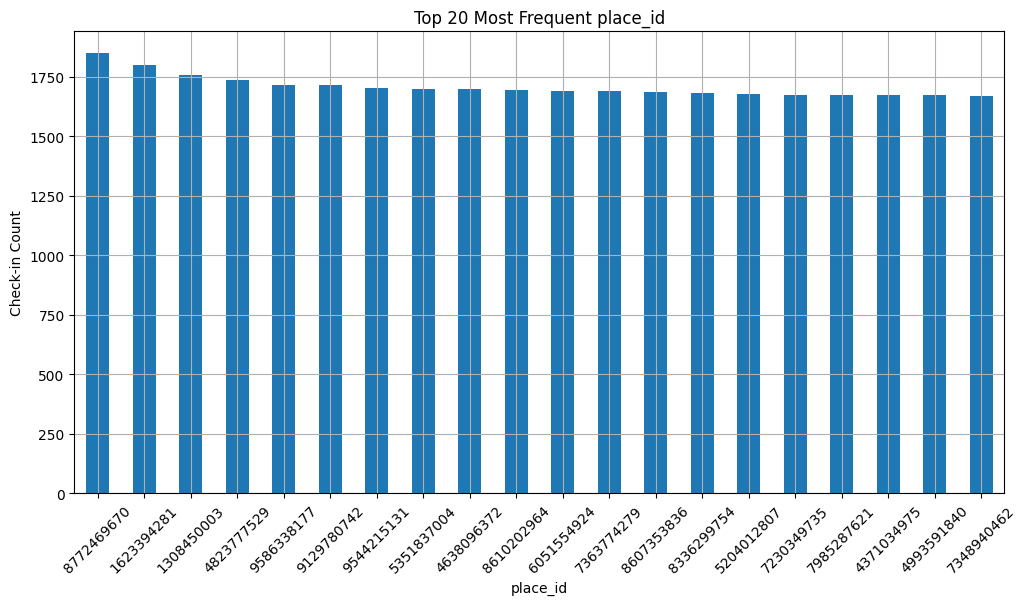

Top 20 place_ids cover 0.12% of total check-ins.


In [ ]:
# We'll see the 20 most repeated place_id,
# and their percentage of total check-ins.

# Top place_ids
top_places = train['place_id'].value_counts().head(20)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
top_places.plot(kind='bar')
plt.title("Top 20 Most Frequent place_id")
plt.xlabel("place_id")
plt.ylabel("Check-in Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Total coverage
coverage = top_places.sum() / len(train)
print(f"Top 20 place_ids cover {coverage:.2%} of total check-ins.")


In [ ]:
# Filter and Feature Engineering

from sklearn.model_selection import train_test_split
import numpy as np

# We'll use only the first 1 million rows for faster training
df = train.copy().head(1_000_000)

# Remove rare place_ids (less than 10 check-ins)
place_counts = df['place_id'].value_counts()
df = df[df['place_id'].isin(place_counts[place_counts >= 10].index)]

# Feature Engineering (already done previously)
df['hour'] = (df['time'] // 60) % 24
df['weekday'] = (df['time'] // (60*24)) % 7
df['month'] = (df['time'] // (60*24*30)) % 12
df['year'] = df['time'] // (60*24*365)

# Selected features for KNN
features = ['x', 'y', 'accuracy', 'hour', 'weekday']
X = df[features]
y = df['place_id']

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Number of classes:", len(le.classes_))


Train shape: (553423, 5)
Number of classes: 34151


In [ ]:
# KNN Model + Top-3 Accuracy Estimation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import time

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=25, weights='distance', n_jobs=-1)

start = time.time()
knn.fit(X_train, y_train)
print("Training time:", round(time.time() - start, 2), "seconds")

# Predict probabilities
y_pred_proba = knn.predict_proba(X_val)

# Top-3 accuracy with full label set provided
all_labels = np.arange(len(le.classes_))  # or: le.transform(le.classes_)

top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3, labels=all_labels)
print(f"\n✅ Top-3 Accuracy (KNN): {top3:.4f}")


Training time: 0.74 seconds

✅ Top-3 Accuracy (KNN): 0.0242


In [ ]:
# Preparing for LGBM Model

# Use the filtered df from earlier (with >=10 place_ids and 1M rows)
grid_size = 10  # creates 10x10 = 100 cells

# Add grid cell features
df['x_bin'] = (df['x'] * grid_size).astype(int)
df['y_bin'] = (df['y'] * grid_size).astype(int)

# Combine x and y bins into a single grid ID
df['grid_id'] = df['x_bin'].astype(str) + "_" + df['y_bin'].astype(str)

# Show sample
df[['x', 'y', 'x_bin', 'y_bin', 'grid_id']].head()


,x,y,x_bin,y_bin,grid_id
0,0.7941,9.0809,7,90,7_90
1,5.9567,4.7968,59,47,59_47
3,7.3665,2.5165,73,25,73_25
4,4.0961,1.1307,40,11,40_11
5,3.8099,1.9586,38,19,38_19


In [ ]:
# Densest Grid and LightGBM Model

# Find most populated grid cell
top_grid = df['grid_id'].value_counts().idxmax()
print(f"Most populated grid: {top_grid}")

# Subset data from that grid
grid_df = df[df['grid_id'] == top_grid].copy()

print("Grid subset shape:", grid_df.shape)
print("Unique place_ids in this grid:", grid_df['place_id'].nunique())


Most populated grid: 82_97
Grid subset shape: (251, 13)
Unique place_ids in this grid: 26


In [ ]:
# Model Training and Top-3 Accuracy Calculation with LightGBM

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode place_id
le_g = LabelEncoder()
grid_df['place_id_encoded'] = le_g.fit_transform(grid_df['place_id'])

# Features and target
features = ['x', 'y', 'accuracy', 'hour', 'weekday']
X = grid_df[features]
y = grid_df['place_id_encoded']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM model
model = lgb.LGBMClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Predict proba for top-3 accuracy
y_pred_proba = model.predict_proba(X_val)

# Evaluate - Filter y_val and y_pred_proba to include only classes in model.classes_
# This is a workaround for the ValueError when y_val contains classes not in model.classes_
model_classes = model.classes_
valid_indices = np.isin(y_val, model_classes)
y_val_filtered = y_val[valid_indices]
y_pred_proba_filtered = y_pred_proba[valid_indices]


top3 = top_k_accuracy_score(y_val_filtered, y_pred_proba_filtered, k=3, labels=model_classes)
print(f"✅ Top-3 Accuracy (LightGBM – Grid {top_grid}): {top3:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 5
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [Info] Start training from score -2.733368
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -3.912023
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [Info] Start training from score -4.605170
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [Info] Start training from score -2.590267
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [Info] Start training from score -5.298317
[LightGBM] [I

     grid_id  samples  classes  top3_acc
36     45_41      119       19       1.0
7183   55_75       51       13       1.0
7192   84_99       70       22       1.0
6239   93_66      103       16       1.0
6231   95_84       65       12       1.0
2466   31_74       76       15       1.0
2407   94_15       74       19       1.0
2417   81_18       59       20       1.0
809    11_52       60       15       1.0
812     80_5       59       17       1.0


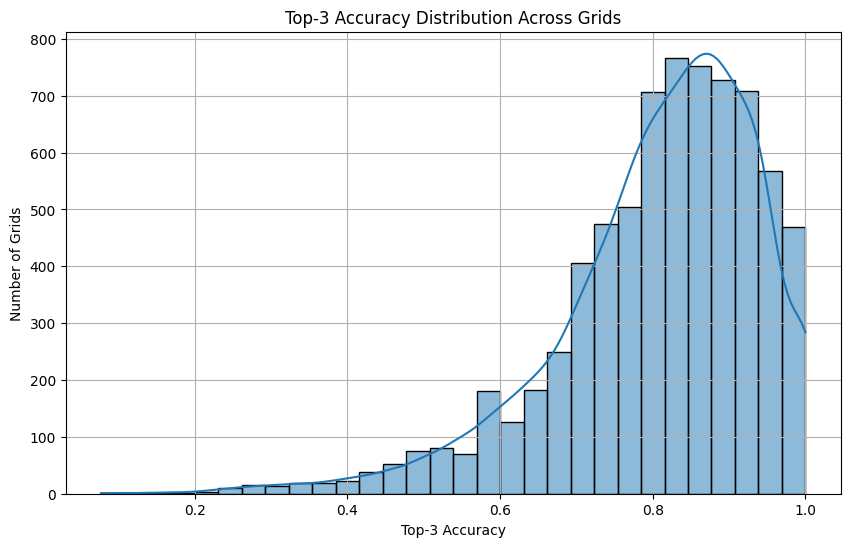

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import top_k_accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = []

# Iterate over each unique grid_id
for grid in df['grid_id'].unique():
    grid_df = df[df['grid_id'] == grid].copy()  # avoid SettingWithCopyWarning

    # Skip very small grids
    if len(grid_df) < 50 or grid_df['place_id'].nunique() < 3:
        continue

    # Encode target
    le = LabelEncoder()
    grid_df['place_id_encoded'] = le.fit_transform(grid_df['place_id'])

    # Features and target
    features = ['x', 'y', 'accuracy', 'hour', 'weekday']
    X = grid_df[features]
    y = grid_df['place_id_encoded']

    # Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train model
    model = lgb.LGBMClassifier(n_estimators=50, verbosity=-1)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_proba = model.predict_proba(X_val)

    # Filter y_val and y_pred_proba to include only classes in model.classes_
    # This is a workaround for the ValueError when y_val contains classes not in model.classes_
    model_classes = model.classes_
    valid_indices = np.isin(y_val, model_classes)
    y_val_filtered = y_val[valid_indices]
    y_pred_proba_filtered = y_pred_proba[valid_indices]


    top3 = top_k_accuracy_score(y_val_filtered, y_pred_proba_filtered, k=3, labels=model_classes)

    results.append({
        'grid_id': grid,
        'samples': len(grid_df),
        'classes': len(le.classes_),
        'top3_acc': top3
    })

# Results DataFrame
results_df = pd.DataFrame(results).sort_values(by='top3_acc', ascending=False)
print(results_df.head(10))

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['top3_acc'], bins=30, kde=True)
plt.title("Top-3 Accuracy Distribution Across Grids")
plt.xlabel("Top-3 Accuracy")
plt.ylabel("Number of Grids")
plt.grid(True)
plt.show()

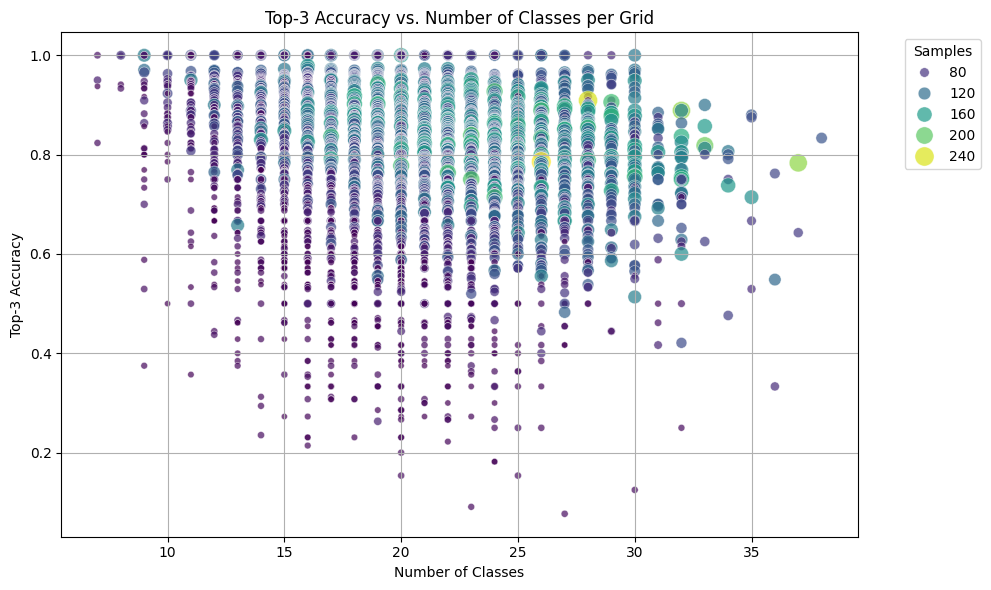

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='classes', y='top3_acc', size='samples', hue='samples', palette='viridis', sizes=(20, 200), alpha=0.7)
plt.title('Top-3 Accuracy vs. Number of Classes per Grid')
plt.xlabel('Number of Classes')
plt.ylabel('Top-3 Accuracy')
plt.grid(True)
plt.legend(title='Samples', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


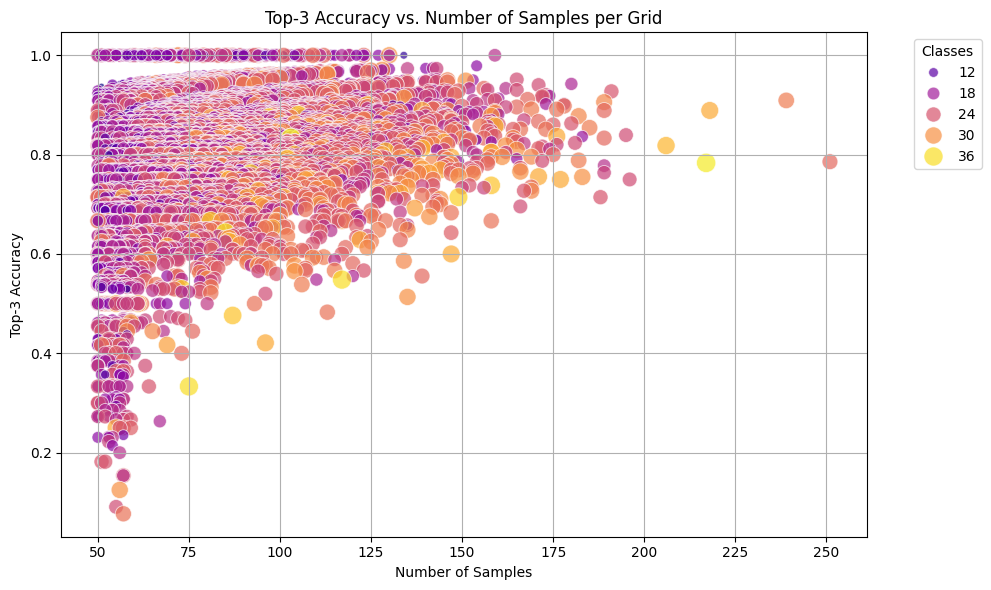

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='samples', y='top3_acc', hue='classes', palette='plasma', size='classes', sizes=(20, 200), alpha=0.7)
plt.title('Top-3 Accuracy vs. Number of Samples per Grid')
plt.xlabel('Number of Samples')
plt.ylabel('Top-3 Accuracy')
plt.grid(True)
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-32-2500744193.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = results_df.pivot_table(


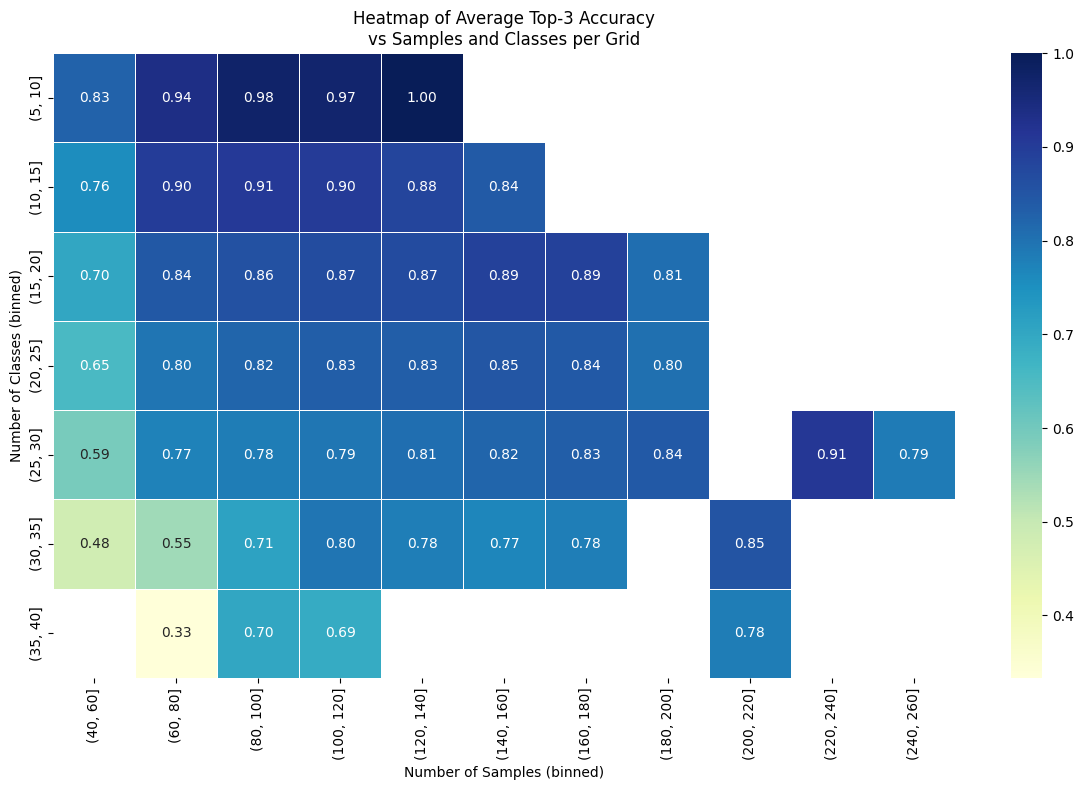

In [ ]:
import numpy as np

# 1️⃣ Bin oluştur: samples ve classes için
results_df['samples_bin'] = pd.cut(results_df['samples'], bins=np.arange(40, 270, 20))
results_df['classes_bin'] = pd.cut(results_df['classes'], bins=np.arange(5, 45, 5))

# 2️⃣ Ortalama Top-3 Accuracy hesapla (pivot tablo)
heatmap_data = results_df.pivot_table(
    values='top3_acc',
    index='classes_bin',
    columns='samples_bin',
    aggfunc='mean'
)

# 3️⃣ Heatmap çizimi
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Average Top-3 Accuracy\nvs Samples and Classes per Grid')
plt.xlabel('Number of Samples (binned)')
plt.ylabel('Number of Classes (binned)')
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import zipfile

# open zip
with zipfile.ZipFile("test.csv.zip") as z:
    with z.open("test.csv") as f:
        test_df = pd.read_csv(f)

# Column names
print(test_df.columns)
print(test_df.head())


Index(['row_id', 'x', 'y', 'accuracy', 'time'], dtype='object')
   row_id       x       y  accuracy    time
0       0  0.1675  1.3608       107  930883
1       1  7.3909  2.5301        35  893017
2       2  8.0978  2.3473        62  976933
3       3  0.9990  1.0591        62  907285
4       4  0.6670  9.7254        40  914399


In [ ]:
# create grid_id

# Bin x and y by 0.1
test_df['x_bin'] = (test_df['x'] * 10).astype(int)
test_df['y_bin'] = (test_df['y'] * 10).astype(int)

# grid_id create
test_df['grid_id'] = test_df['x_bin'].astype(str) + "_" + test_df['y_bin'].astype(str)

# Add time components (must be the same pipeline as the train)
test_df['hour'] = (test_df['time'] // 60) m% 24
test_df['weekday'] = (test_df['time'] // (60*24)) % 7
test_df['month'] = (test_df['time'] // (60*24*30)) % 12
test_df['year'] = test_df['time'] // (60*24*365)


In [ ]:
# create submission

import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1️⃣ Load training data from zip
with zipfile.ZipFile("train.csv.zip") as z:
    with z.open("train.csv") as f:
        train_df = pd.read_csv(f)

# 2️⃣ Preprocess training data (same as test)
train_df['x_bin'] = (train_df['x'] * 10).astype(int)
train_df['y_bin'] = (train_df['y'] * 10).astype(int)
train_df['grid_id'] = train_df['x_bin'].astype(str) + "_" + train_df['y_bin'].astype(str)

train_df['hour'] = (train_df['time'] // 60) % 24
train_df['weekday'] = (train_df['time'] // (60*24)) % 7
train_df['month'] = (train_df['time'] // (60*24*30)) % 12
train_df['year'] = train_df['time'] // (60*24*365)

# 3️⃣ Initialize prediction list
predictions = []

# 4️⃣ Iterate over unique grid_ids
for grid in tqdm(test_df['grid_id'].unique()):
    train_subset = train_df[train_df['grid_id'] == grid]
    test_subset = test_df[test_df['grid_id'] == grid].copy()

    if len(train_subset) < 50 or train_subset['place_id'].nunique() < 3:
        continue  # Skip low-data grids

    # Encode labels
    le = LabelEncoder()
    train_subset.loc[:, 'place_id_encoded'] = le.fit_transform(train_subset['place_id'])

    features = ['x', 'y', 'accuracy', 'hour', 'weekday']
    X_train = train_subset[features]
    y_train = train_subset['place_id_encoded']
    X_test = test_subset[features]

    # Train model
    model = lgb.LGBMClassifier(n_estimators=50, verbosity=-1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)
    top_3 = np.argsort(y_proba, axis=1)[:, -3:][:, ::-1]  # Top-3 in descending order

    # Map predictions back to place_id
    top_3_labels = np.array([le.inverse_transform(row) for row in top_3])

    # Format as space-separated string
    test_subset['place_id'] = [' '.join(map(str, preds)) for preds in top_3_labels]

    # Save row_id and predicted place_ids
    predictions.append(test_subset[['row_id', 'place_id']])

# 5️⃣ Combine all predictions and save
submission_df = pd.concat(predictions)
submission_df = submission_df.sort_values('row_id')
submission_df.to_csv("submission.csv", index=False)
print("✅ Submission file created: submission.csv")


Streaming output truncated to the last 5000 lines.
  train_subset.loc[:, 'place_id_encoded'] = le.fit_transform(train_subset['place_id'])
 78%|███████▊  | 7803/10033 [9:45:26<2:43:38,  4.40s/it]/tmp/ipython-input-42-759873231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_subset.loc[:, 'place_id_encoded'] = le.fit_transform(train_subset['place_id'])
 78%|███████▊  | 7804/10033 [9:45:30<2:41:30,  4.35s/it]/tmp/ipython-input-42-759873231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s

In [ ]:
import joblib

# save
joblib.dump(model, "model_45_41.pkl")
joblib.dump(le, "le_45_41.pkl")


['le_45_41.pkl']